In [ ]:
##Importing all necessary libraries
import os
import shutil
import torch
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score,roc_curve, auc
from collections import OrderedDict
from torchsummary import summary
import torchvision.models as models
import time


In [ ]:
##Connecting to the drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
##Accesing the dataset
data_dir = '/drive/My Drive/Colab Notebooks/Original Dataset'
raw_dataset = datasets.ImageFolder(root=data_dir)

class_names = raw_dataset.classes
print("Class Names:", class_names)

Class Names: ['Black Spot', 'Downy Mildew', 'Fresh Leaf']


In [ ]:
print ('Dataset Shape:', len(raw_dataset))

def class_shape(x):
    class_info = {}
    for class_name in x.classes:
        class_index = x.class_to_idx[class_name]
        num_images = len([img for img, idx in x.imgs if idx == class_index])
        class_info[class_name] = num_images
        print(class_name,':',num_images)
    return class_info

class_info = class_shape(raw_dataset)


Dataset Shape: 917
Black Spot : 313
Downy Mildew : 200
Fresh Leaf : 404


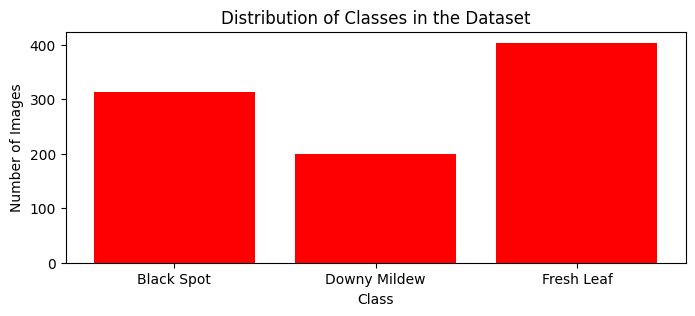

In [ ]:
##Visualization of the Dataset
class_names = list(class_info.keys())
num_images = list(class_info.values())

plt.figure(figsize=(8, 3))
plt.bar(class_names, num_images, color='red')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Dataset')
plt.show()

In [ ]:
##Data Augmentation
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
##Creating a new folder
augmented_dataset_root = '/drive/My Drive/Colab Notebooks/Augmented dataset'
os.makedirs(augmented_dataset_root, exist_ok=True)

In [ ]:
##Creating folder according to class names
for class_name in raw_dataset.classes:
    class_folder_path = os.path.join(augmented_dataset_root, class_name)
    os.makedirs(class_folder_path, exist_ok=True)

In [ ]:
##Finding the largest class
largest_class_name = max(class_info, key=class_info.get)
max_num_img = class_info[largest_class_name]
print("Name of the largest class:",largest_class_name)
print("Number of images in the largest class:",max_num_img)
desire_num_img=max_num_img*4
print("Desired Number of Images:", desire_num_img)

Name of the largest class: Fresh Leaf
Number of images in the largest class: 404
Desired Number of Images: 1616


In [ ]:
##Renaming the original Images
source_dir = data_dir

for class_name in os.listdir(source_dir):
    class_source_dir = os.path.join(source_dir, class_name)

    counter = 1
    for filename in os.listdir(class_source_dir):
        if filename.endswith('.jpg'):
            source_file = os.path.join(class_source_dir, filename)
            new_filename = os.path.join(class_source_dir, f"{counter}.jpg")
            os.rename(source_file, new_filename)
            counter += 1

print("Images renamed successfully.")

Images renamed successfully.


In [ ]:
##Creating Augmented Images
source_dir = data_dir
destination_root = augmented_dataset_root
counter = 1

for class_name in os.listdir(source_dir):
    class_source_dir = os.path.join(source_dir, class_name)
    class_destination_dir = os.path.join(destination_root, class_name)

    num_images = len([name for name in os.listdir(class_source_dir) if name.endswith('.jpg')])
    augmentation_factor = int(desire_num_img / num_images)  # Calculate augmentation factor

    for filename in os.listdir(class_source_dir):
        if filename.endswith('.jpg'):
            source_file = os.path.join(class_source_dir, filename)
            img = Image.open(source_file).convert('RGB')

            for i in range(augmentation_factor):
                augmented_img = transform(img)
                save_path = os.path.join(class_destination_dir, f"{class_name}_aug_{counter}.jpg")
                torchvision.utils.save_image(augmented_img, save_path)
                counter += 1

print('Augmented images are successfully saved.')

Augmented images are successfully saved.


In [ ]:
another_transform= transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
##Aplying data augmentation to the new dataset
augmented_dataset = datasets.ImageFolder(root=augmented_dataset_root, transform=another_transform)
print("Augmented Dataset Shape:", len(augmented_dataset))


Augmented Dataset Shape: 4781


In [ ]:
new_class_info = class_shape(augmented_dataset)


Black Spot : 1565
Downy Mildew : 1600
Fresh Leaf : 1616


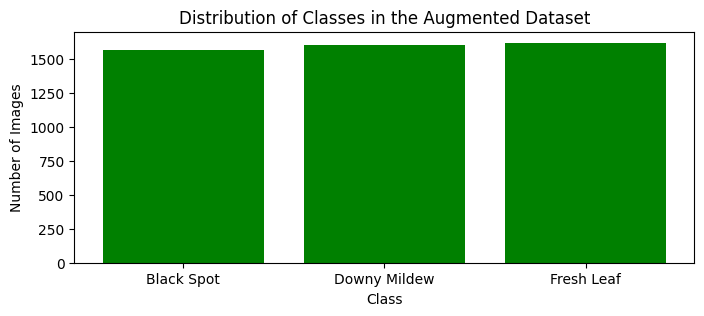

In [ ]:
##Visualization of the new Dataset
class_names = list(new_class_info.keys())
num_images = list(new_class_info.values())

plt.figure(figsize=(8, 3))
plt.bar(class_names, num_images, color='green')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Augmented Dataset')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
num_epochs = 16
batch_size = 32
learning_rate = 0.001

In [ ]:
dataloader = torch.utils.data.DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
##Seperating the dataset into train, test and validation
train_size = int(0.7 * len(augmented_dataset))
remaining_data = len(augmented_dataset) - train_size
validation_size = remaining_data // 2
test_size = remaining_data - validation_size
train_dataset, validation_dataset, test_dataset = random_split(augmented_dataset, [train_size, validation_size, test_size])



In [ ]:
print("Train Dataset Shape: ",len(train_dataset))
print("Validation Dataset Shape: ",len(validation_dataset))
print("Test Dataset Shape: ",len(test_dataset))

Train Dataset Shape:  3346
Validation Dataset Shape:  717
Test Dataset Shape:  718


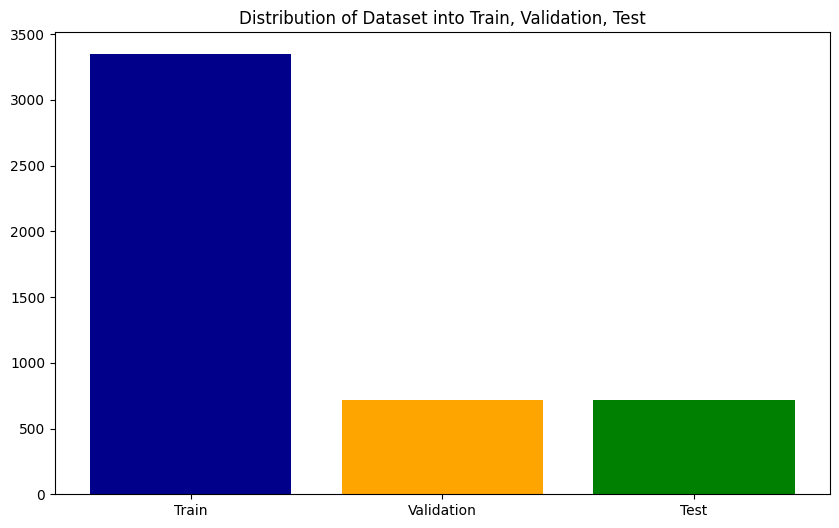

In [ ]:
##Visualization of Dataset distribution
sizes = [len(train_dataset), len(validation_dataset), len(test_dataset)]
labels = ['Train', 'Validation', 'Test']
colors = ['darkblue', 'orange', 'green']

plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=colors)

plt.title('Distribution of Dataset into Train, Validation, Test')
plt.show()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
##Training the model
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
    plot_training = []
    plot_validation = []

    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait if validation loss doesn't improve
    wait = 0  # Counter for patience
    best_model_weights = None
    model.to(device)
    for e in range(epochs):

        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate performance on validation set
        model.eval()
        val_loss = 0
        val_accuracy = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to GPU

                output = model(images)
                val_loss += criterion(output, labels).item()
                _, predicted = torch.max(output, 1)
                val_accuracy += (predicted == labels).float().mean().item()

        # Calculate average loss and accuracy
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {e+1}')
                break

        print(
            f"Epoch: {e + 1}/{epochs}, "
            f"Avg. Training Loss: {avg_train_loss:.4f}, "
            f"Avg. Validation Loss: {avg_val_loss:.4f}, "
            f"Avg. Validation Accuracy: {avg_val_accuracy:.4f}"
        )

        plot_training.append(avg_train_loss)
        plot_validation.append(avg_val_loss)
    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    plt.plot(range(len(plot_training)), plot_training, label='Training Loss')
    plt.plot(range(len(plot_validation)), plot_validation, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


In [ ]:
##Resnet50
res_model = models.resnet50(weights=True)
res_model=res_model.to(device)
print(res_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze pretrained model parameters
for parameter in res_model.parameters():
    parameter.requires_grad = False

In [ ]:
print("Original final layer")
print(res_model.fc)

# Modifying Final Layer
train_dataset= train_dataset.dataset
class_mapping =train_dataset.class_to_idx
num_classes = len(class_mapping)
num_ftrs = res_model.fc.in_features

classifier = nn.Sequential(
    OrderedDict([
        ("fc", nn.Linear(num_ftrs, num_classes)),
    ])
)
res_model.fc = classifier

print("\nModified final layer")
print(res_model.fc)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer
Sequential(
  (fc): Linear(in_features=2048, out_features=3, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_model.fc.parameters(), lr=learning_rate)

Epoch: 1/16, Avg. Training Loss: 0.5497, Avg. Validation Loss: 0.3732, Avg. Validation Accuracy: 0.8608
Epoch: 2/16, Avg. Training Loss: 0.3333, Avg. Validation Loss: 0.2885, Avg. Validation Accuracy: 0.8880
Epoch: 3/16, Avg. Training Loss: 0.3097, Avg. Validation Loss: 0.2642, Avg. Validation Accuracy: 0.9111
Epoch: 4/16, Avg. Training Loss: 0.2756, Avg. Validation Loss: 0.2559, Avg. Validation Accuracy: 0.9083
Epoch: 5/16, Avg. Training Loss: 0.2583, Avg. Validation Loss: 0.2345, Avg. Validation Accuracy: 0.9151
Epoch: 6/16, Avg. Training Loss: 0.2512, Avg. Validation Loss: 0.2288, Avg. Validation Accuracy: 0.9064
Epoch: 7/16, Avg. Training Loss: 0.2410, Avg. Validation Loss: 0.3106, Avg. Validation Accuracy: 0.8492
Epoch: 8/16, Avg. Training Loss: 0.2267, Avg. Validation Loss: 0.2244, Avg. Validation Accuracy: 0.9145
Epoch: 9/16, Avg. Training Loss: 0.2382, Avg. Validation Loss: 0.2120, Avg. Validation Accuracy: 0.9165
Epoch: 10/16, Avg. Training Loss: 0.2391, Avg. Validation Loss: 

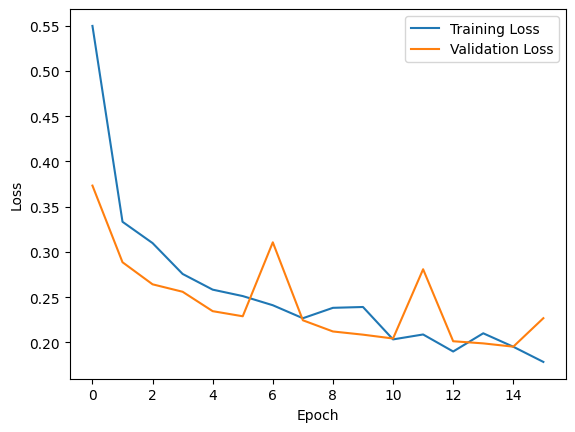

Total Time for Training 452.6542479991913


In [ ]:
start_time = time.time()
resnet_model = train_model(res_model, optimizer, criterion, train_loader, val_loader)
total_time = time.time() - start_time
print("Total Time for Training",total_time)

In [ ]:
##Testing the model
from sklearn.metrics import classification_report
def test_model(model, test_loader,num_images=5):
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        print(f"Accuracy: {accuracy * 100:.2f}%")

        predictions = []
        true_labels = []

        for images, labels in iter(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)
            predictions += predicted.cpu().tolist()
            true_labels += labels.cpu().tolist()

        classes = test_loader.dataset.dataset.classes
        class_names = [classes[i] for i in range(len(classes))]

        print(classification_report(true_labels, predictions, target_names=class_names))

        classes = test_loader.dataset.dataset.classes
        num_rows = (num_images + 2) // 3  # Calculate the number of rows needed for the grid
        fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

        for i, (image, label) in enumerate(test_loader.dataset):
            if i >= num_images:
                break
            row_idx = i // 3
            col_idx = i % 3
            image = np.transpose(image.numpy(), (1, 2, 0))
            axs[row_idx, col_idx].imshow(image)
            axs[row_idx, col_idx].axis('off')
            actual_class = classes[label]
            predicted_class = classes[predictions[i]]
            axs[row_idx, col_idx].set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")
        for i in range(num_images, num_rows * 3):
            row_idx = i // 3
            col_idx = i % 3
            axs[row_idx, col_idx].axis('off')

        plt.tight_layout()
        plt.show()




Accuracy: 89.69%
              precision    recall  f1-score   support

  Black Spot       0.82      0.92      0.87       250
Downy Mildew       0.99      0.98      0.98       229
  Fresh Leaf       0.90      0.79      0.84       239

    accuracy                           0.90       718
   macro avg       0.90      0.90      0.90       718
weighted avg       0.90      0.90      0.90       718



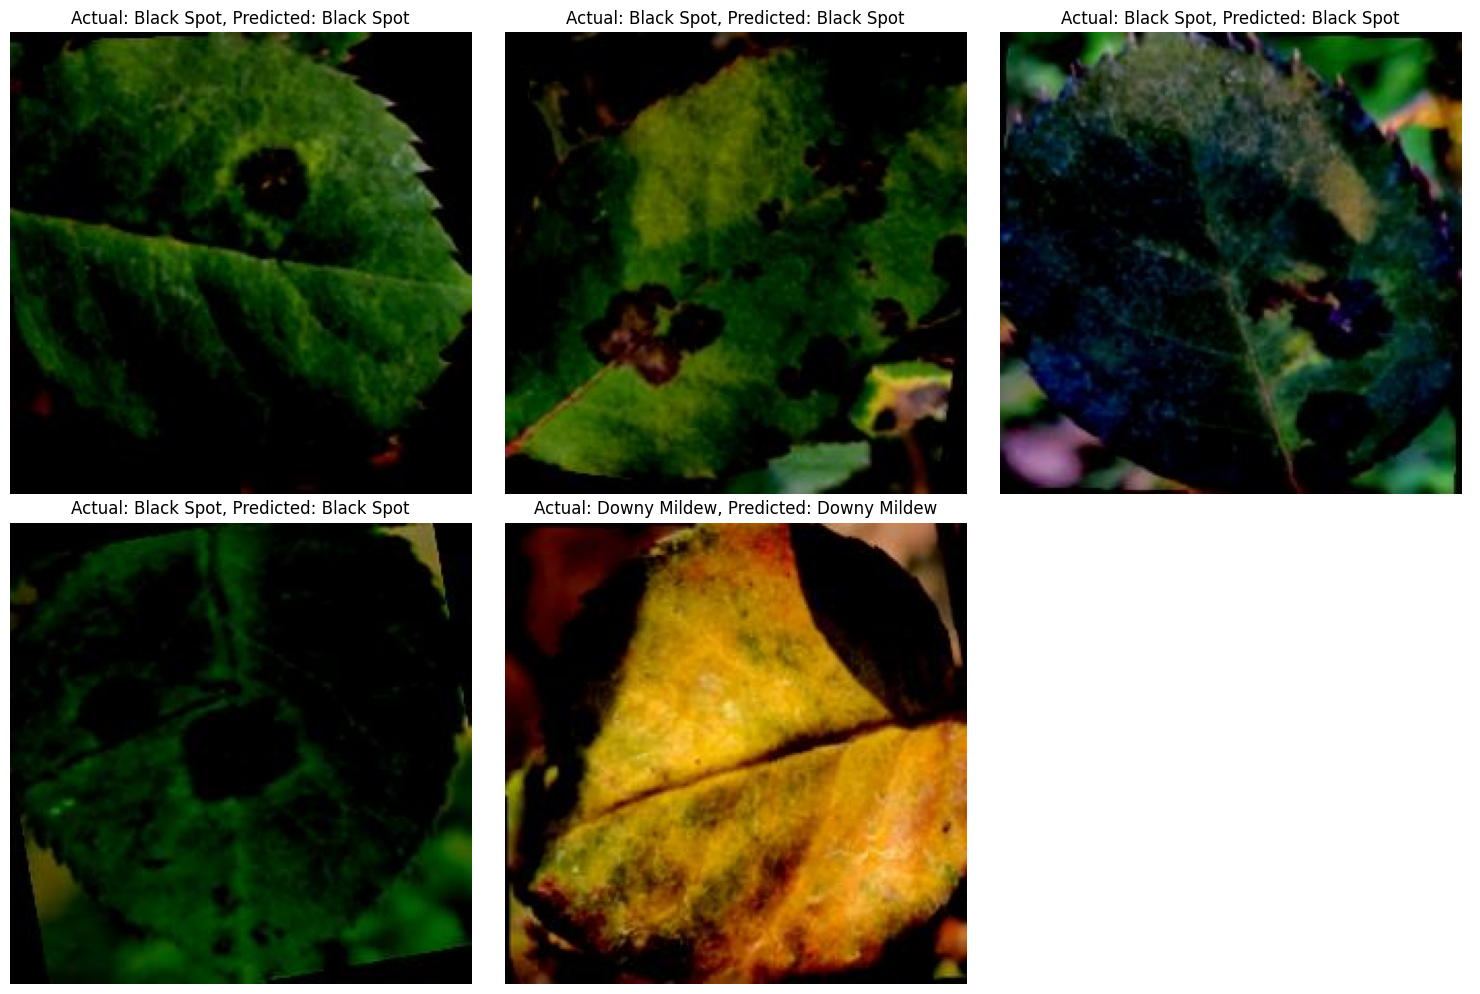

In [ ]:
test_resnet=test_model(resnet_model, test_loader,num_images=5)
test_resnet

In [ ]:
##VGG16
vgg_model = models.vgg16(weights=True)
vgg_model=vgg_model.to(device)

print(vgg_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 99.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freeze pretrained model parameters
for parameter in vgg_model.parameters():
    parameter.requires_grad = False

In [ ]:
print("Original final layer")
print(vgg_model.classifier)

# Modifying final layer
num_classes = len(class_mapping)

classifier = nn.Sequential(
    nn.Linear(4096, num_classes)
)
vgg_model.classifier[-1] = classifier

print("\nModified final layer")
print(vgg_model.classifier)


Original final layer
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Modified final layer
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=3, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.classifier.parameters(), lr=learning_rate)


Epoch: 1/16, Avg. Training Loss: 0.5203, Avg. Validation Loss: 0.3594, Avg. Validation Accuracy: 0.8478
Epoch: 2/16, Avg. Training Loss: 0.3947, Avg. Validation Loss: 0.3125, Avg. Validation Accuracy: 0.8777
Epoch: 3/16, Avg. Training Loss: 0.3605, Avg. Validation Loss: 0.2973, Avg. Validation Accuracy: 0.8703
Epoch: 4/16, Avg. Training Loss: 0.3447, Avg. Validation Loss: 0.2836, Avg. Validation Accuracy: 0.8913
Epoch: 5/16, Avg. Training Loss: 0.3222, Avg. Validation Loss: 0.2722, Avg. Validation Accuracy: 0.8940
Epoch: 6/16, Avg. Training Loss: 0.3199, Avg. Validation Loss: 0.2616, Avg. Validation Accuracy: 0.8995
Epoch: 7/16, Avg. Training Loss: 0.3108, Avg. Validation Loss: 0.2610, Avg. Validation Accuracy: 0.8907
Epoch: 8/16, Avg. Training Loss: 0.3111, Avg. Validation Loss: 0.2483, Avg. Validation Accuracy: 0.9144
Epoch: 9/16, Avg. Training Loss: 0.2954, Avg. Validation Loss: 0.2416, Avg. Validation Accuracy: 0.9144
Epoch: 10/16, Avg. Training Loss: 0.3008, Avg. Validation Loss: 

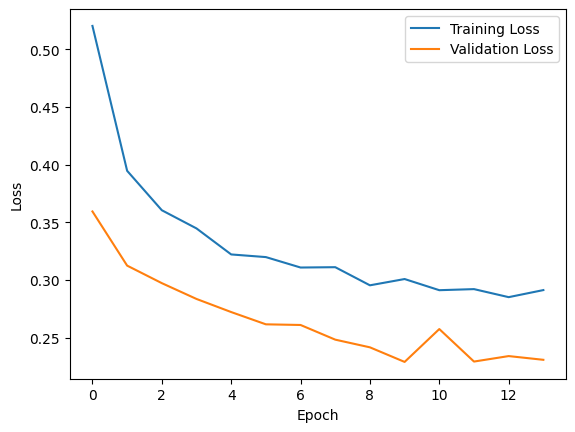

Total Time for Training 526.5515730381012


In [ ]:
start_time = time.time()
vgg_model = train_model(vgg_model, optimizer, criterion, train_loader, val_loader)
total_time = time.time() - start_time
print("Total Time for Training",total_time)

Accuracy: 90.53%
              precision    recall  f1-score   support

  Black Spot       0.93      0.83      0.88       250
Downy Mildew       0.95      0.98      0.96       229
  Fresh Leaf       0.84      0.91      0.88       239

    accuracy                           0.91       718
   macro avg       0.91      0.91      0.91       718
weighted avg       0.91      0.91      0.90       718



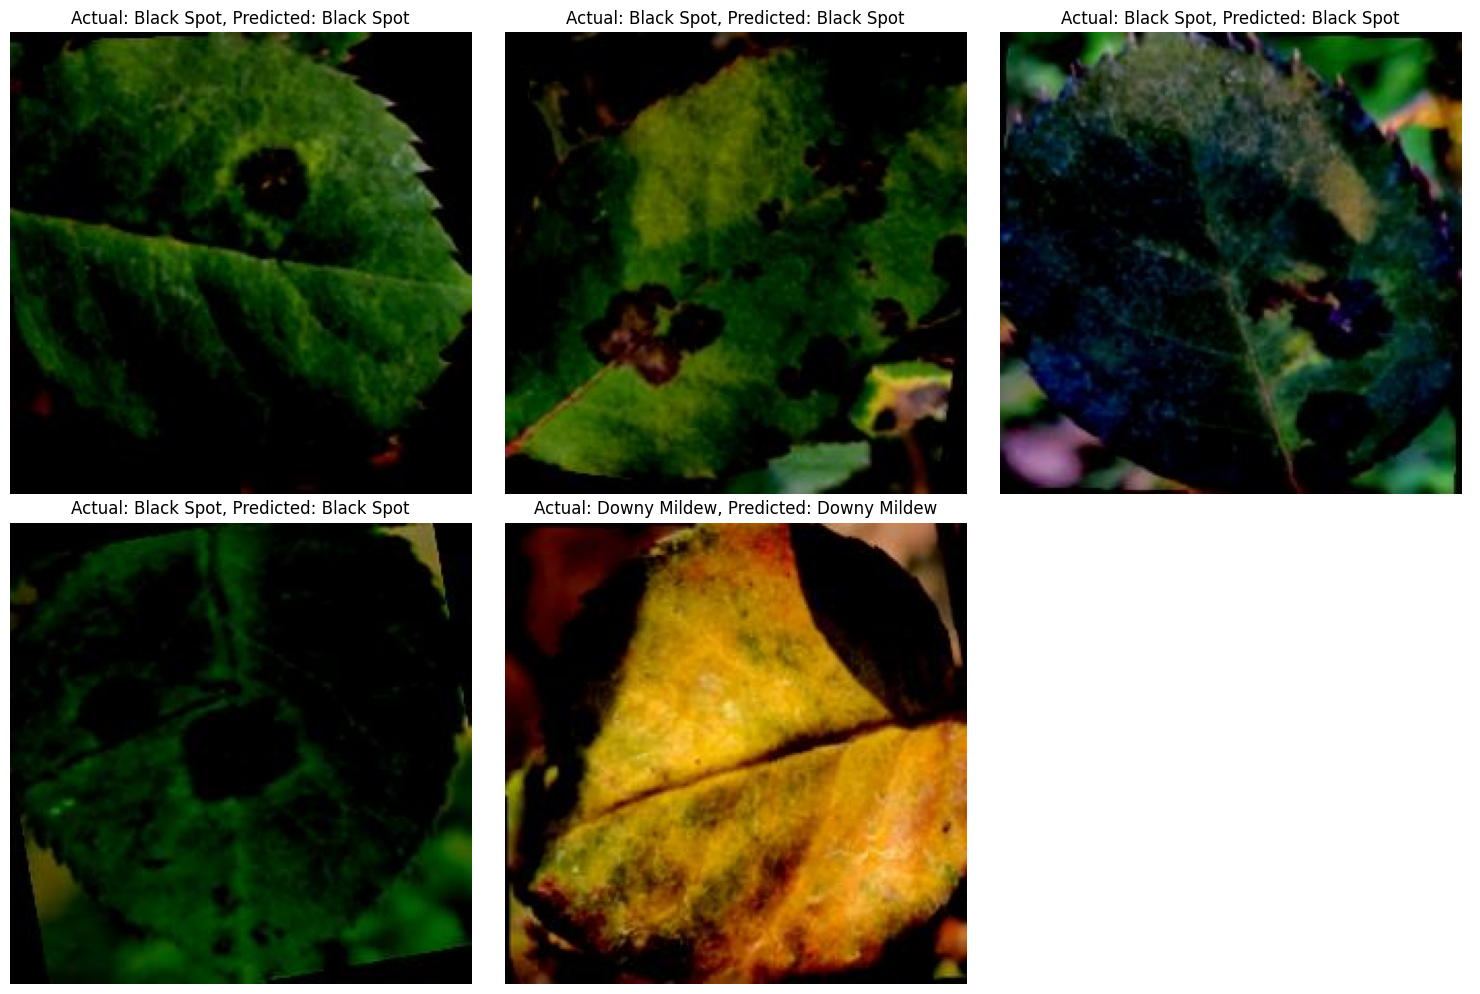

In [ ]:
test_vgg=test_model(vgg_model, test_loader,num_images=5)
test_vgg